This notebook is designed to showcase the power of [lvlspy](https://pypi.org/project/lvlspy/) as an API by using it replicate the results from [Gupta and Meyer](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.64.025805). The paper focuses on calculating the equilibration rate between the isomeric state and the ground state of $^{26}\mathrm{Al}$. The methods built into [lvlspy](https://pypi.org/project/lvlspy/) are based on that publication.

To kick things off, we will quietly install any missing packages required for lvlspy and import all the packages required for this notebook. Most are built-in or installed with lvlspy.

In [1]:
#importing system libraries
import sys,subprocess,importlib.util, io, requests

#checking and installing required packages
required  = {'lvlspy','matplotlib','tabulate'}
installed = {pkg for pkg in required if importlib.util.find_spec(pkg) is not None}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

#import libraries and modules
import tabulate
import numpy as np
import lvlspy.spcoll as lc
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from lvlspy.io import ensdf
from lvlspy.calculate import isomer, evolve
from IPython.display import HTML, display, Math

Now that all the packages are installed, let us first download an ENSDF file, found on [OSF](https://osf.io/76qc3), and load into lvlspy

In [2]:
!curl -o ensdf.026 -JL https://osf.io/76qc3/download #Downloads the ENSDF file containing Al26 data

new_coll = lc.SpColl() #creates a new lvlspy collection
ensdf.update_from_ensdf(new_coll,'ensdf.026','al26') #loads the file into the collection

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   439  100   439    0     0    923      0 --:--:-- --:--:-- --:--:--   928

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100  893k  100  893k    0     0   329k      0  0:00:02  0:00:02 --:--:--  880k
curl: (3) URL rejected: No host part in the URL
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
 

Now let's be sure the file was read and print out the first few levels and their properties

In [3]:
al26 = new_coll.get()['al26']

print('Species: ' + al26.get_name())
print('Level Index        Energy (keV)        Multiplicity        ENSDF JPI')
levels = al26.get_levels()

for i in range(6):
    energy = levels[i].get_energy()
    multip = levels[i].get_multiplicity()
    ensdfjp = levels[i].get_properties()['j^pi']
    print(str(i).center(11) + '        ' + str(energy).center(12) + '        ' + str(multip).center(12) + '        ' + ensdfjp.center(9))

Species: al26
Level Index        Energy (keV)        Multiplicity        ENSDF JPI
     0                 0.0                  11                 5+   
     1               228.305                1                  0+   
     2               416.852                7                  3+   
     3               1057.739               3                  1+   
     4               1759.034               5                  2+   
     5               1850.62                3                  1+   


In the Gupta and Meyer paper, they only used 67 levels and modified some of the transitions' reduced matrix coefficients extracted from [Coc et al](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.61.015801). We will trim the loaded the loaded levels and transitions, then update the reduced matrix coefficients for the specific transitions.

In [4]:
#here we trim the levels from level 67 till the end keeping levels 0 through 66.
#the API will automatically remove the transitions associated with the removed
#levels.

for i in range(67,len(levels)):
    al26.remove_level(levels[i])


Some level to level transitions don't exist in the ENSDF record. In the case of $^{26}\mathrm{Al}$, one example is from the isomer state to the ground as indicated by the True boolean below.

In [5]:
t = al26.get_level_to_level_transition(levels[1],levels[0])
print(t is None)

True


To fill the missing transitions, we can use the built in API that will create the non-recording transiton and calculate an associated Einstein A coefficient based on a Weisskopf esitimate.

In [6]:
ensdf.fill_missing_ensdf_transitions(al26,26)
t = al26.get_level_to_level_transition(levels[1],levels[0])
print('Upper_level = ', levels.index(t.get_upper_level()), 'to lower level = ', levels.index(t.get_lower_level()), 'with Einstein A coefficient: ', t.get_einstein_a())

Upper_level =  1 to lower level =  0 with Einstein A coefficient:  3.833555795514418e-17


Now we'll update some of the transitions

In [ ]:
levels = al26.get_levels() #reinitialize the levels variable to include the levels from the trimmed species

#let's create an iterable list involving the new used from Coc et al.
#2 -> 1 BM3W = 1206
#2 -> 0 BE2W = 36
#3 -> 2 BE2W = 5.8
#3 -> 1 BM1W = 9.7

new_data = [(2,1,'BM3W',1206),(2,0,'BE2W',36),(3,2,'BE2W',5.8),(3,1,'BM1W',2.76)]
for i in new_data:
    t = al26.get_level_to_level_transition(levels[i[0]],levels[i[1]])
    rmc = [(i[2],i[3])]
    ensdf.update_reduced_matrix_coefficient(al26,26,t,rmc)

(2, 1, 'BM3W', 1206)
(2, 0, 'BE2W', 36)
(3, 2, 'BE2W', 5.8)
(3, 1, 'BM1W', 2.76)


Now that the data has been trimmed, updated, and connected, let us replicate figure 1 from Gupta and Meyer.

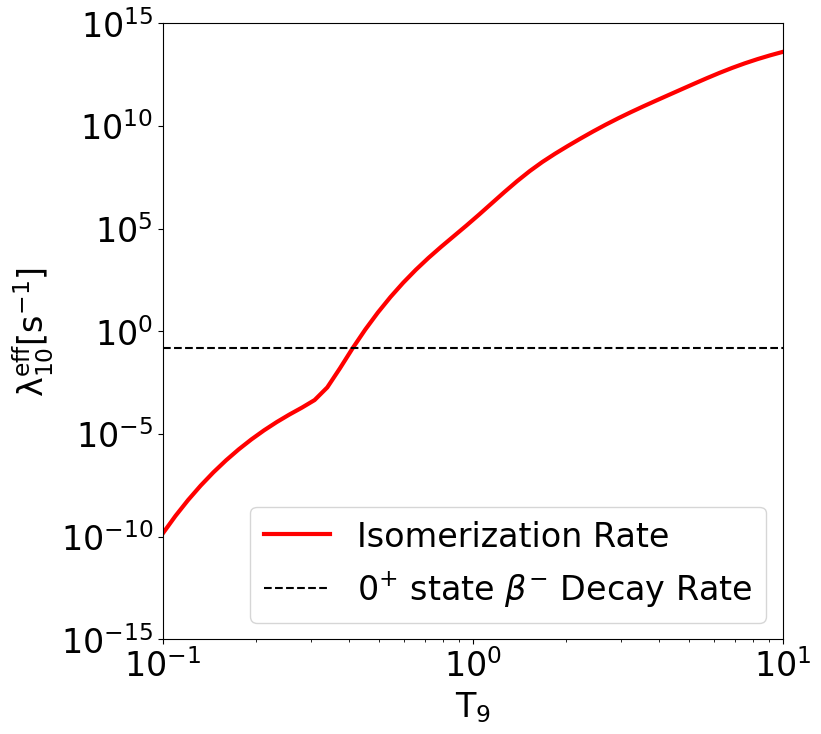

In [8]:
T = np.logspace(8,10) #setting the temperature array

#initializing the rate arrays
l_10 = np.empty(len(T))
l_01 = np.empty(len(T))

for i,t in enumerate(T):
    l_01[i], l_10[i] = isomer.effective_rate(t,al26)

#Set the fontsize and graph
fontsize = 24

plt.figure(figsize = (8,8))
plt.rcParams['font.size'] = fontsize
plt.xscale('log')
plt.yscale('log')

plt.ylim([1.e-15,1.e+15])
plt.xlim([np.min(T)/1e+9,np.max(T)/1e+9])

plt.plot(T/1e+9,l_10,color = 'red',linewidth = 3,label = 'Isomerization Rate')

plt.ylabel(r'$\mathrm{\lambda_{10}^{eff} [s^{-1}]}$')
plt.xlabel(r'$\mathrm{T_{9}}$')

plt.yticks([1e-15,1e-10,1e-5,1e0,1e+5,1e+10,1e+15])

plt.axhline(y = 0.158,ls = '--',color = 'black',label = r'$0^{+}$ state $\beta^{-}$ Decay Rate')#Al26 beta-decay rate

plt.legend(loc = 'lower right')
plt.show()

The difference between the label is due to an indexing choice. In the paper, the label the ground and isomeric states 1 and 2 respectively. Throughout this notebook, we'll follow the python indexing for simplicity. There is also a missing curve from the graph that's not in the figure that we will address now.

Let's say you want see which levels are affecting the isomerization rate the most. lvlspy allows us to remove and levels and add levels easily. We will do this to test the importance certain transitions have on the entire isomerization rate.

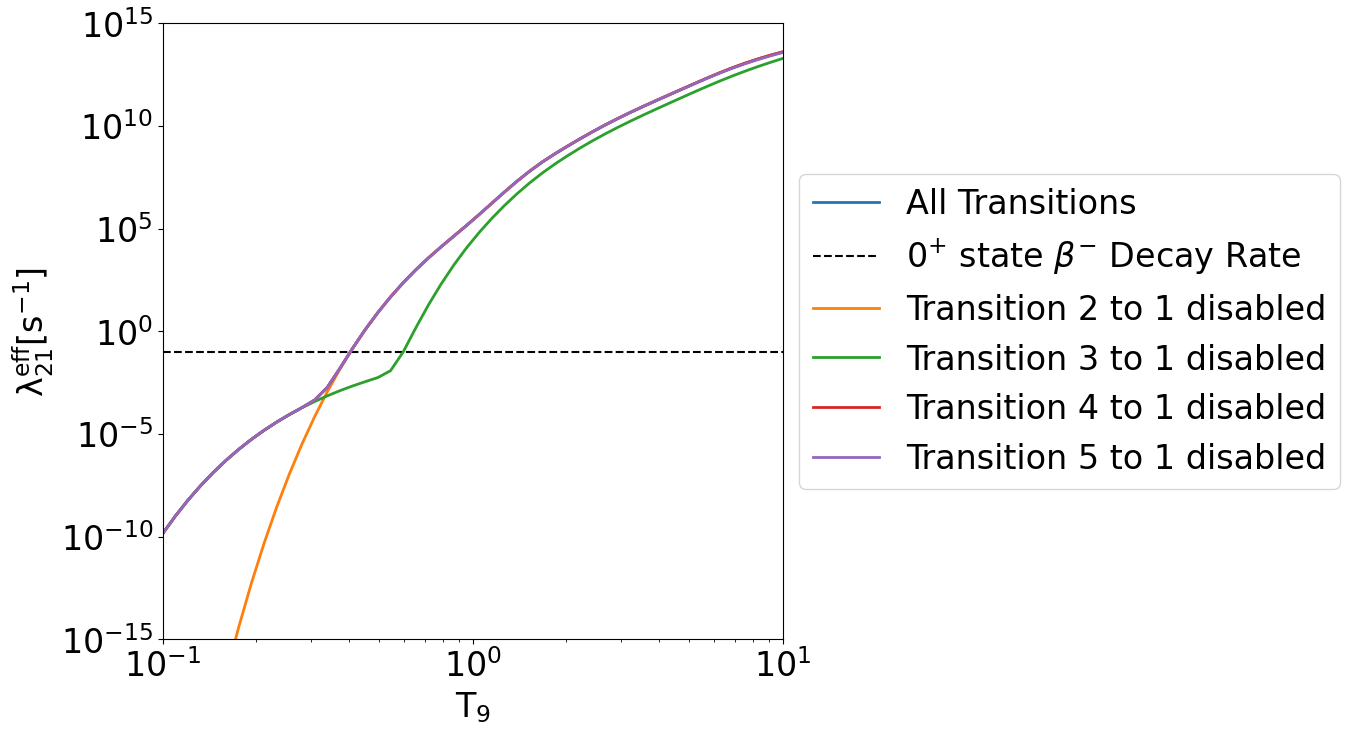

In [ ]:
#re-using the previous graph with the original calculation

plt.figure(figsize = (8,8))
plt.rcParams['font.size'] = fontsize
plt.xscale('log')
plt.yscale('log')

plt.ylim([1.e-15,1.e+15])
plt.xlim([np.min(T)/1e+9,np.max(T)/1e+9])

plt.plot(T/1e+9,l_10,linewidth = 2,label = 'All Transitions')

plt.ylabel(r'$\mathrm{\lambda_{10}^{eff} [s^{-1}]}$')
plt.xlabel(r'$\mathrm{T_{9}}$')

plt.yticks([1e-15,1e-10,1e-5,1e0,1e+5,1e+10,1e+15])

plt.axhline(y = 1.e-1,ls = '--',color = 'black',label = r'$0^{+}$ state $\beta^{-}$ Decay Rate')

#removing transitions, graphing the result, then returning it before removing the next
levels = al26.get_levels()
for i in range(2,6):
    t_remove = al26.get_level_to_level_transition(levels[i],levels[1])
    #removing the transition
    al26.remove_transition(t_remove)
    lambda_10_eff = np.empty(len(T))
    lambda_01_eff = np.empty(len(T)) 
    for j,t in enumerate(T):
        lambda_01_eff[j],lambda_10_eff[j] = isomer.effective_rate(t,al26)
    #adding it back after the calculations
    al26.add_transition(t_remove)
    plt.plot(T/1e+9,lambda_10_eff,linewidth = 2,label = 'Transition '+str(i)+ ' to 1 disabled')

plt.legend(loc = 'center left',bbox_to_anchor=(1,0.5))
plt.show()

The transitions that most affect the isomerization rate are 2 $\rightarrow$ 1 and 3 $\rightarrow$ 1. As the graph makes clear, a simple loop can allow any theorist to probe around which transitions are important to the overall effective rate. A powerful tool to help guide both theorists and experimentalists alike